# Time Series Modeling for Real Estate Investments

*Problem Statement*



In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

#customising our plotting fonts
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 10}

plt.rc('font', **font)

plt.style.use('fivethirtyeight')

#timeseries
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA


import time


In [2]:
#import data set

data  = pd.read_csv('zillow_data.csv')

data.shape

(14723, 272)

In [3]:
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
#checking number of columns
data.columns

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', '1996-04', '1996-05', '1996-06',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=272)

In [5]:
#defing a function to check for missing values
def missing_data(df):
    missing_data = df.isna().sum()
    missing_data = missing_data[missing_data>0]
    return missing_data.to_frame()

In [6]:
#checking for missing values 
data[['RegionID', 'RegionName', 'City', 'Metro', 'CountyName', 'SizeRank' ]].isna().sum()

RegionID         0
RegionName       0
City             0
Metro         1043
CountyName       0
SizeRank         0
dtype: int64

In [7]:
#checkig for number of unique states
data['State'].nunique()

51

In [8]:
#checking for the unique values for metro feature
data['Metro'].nunique()

701

## Data Cleaning

In [9]:
#renaming the Region names to Zipcode

data.rename(columns= {'RegionName': 'ZipCode'}, inplace= True)

In [10]:
#sanity check
data.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


Notice that the 8th feature comprises the dates when the valuation of the house was performed. However, the columns are identified as strings. In the following steps, the columns will be converted to datetime format to allow for manipulation.

In [11]:
def get_datetimes(df):
    """
    Takes a dataframe and converts the column names starting from the 8th column
    to datetime objects, returning the modified dataframe.
    """
    # Convert the column names starting from the 8th column to datetime objects
    datetime_columns = pd.to_datetime(df.columns.values[7:], format='%Y-%m')
    
    # Replace the original column names with the new datetime objects
    df.columns = list(df.columns.values[:7]) + list(datetime_columns)
    
    return df

# Applying the function to the data dataframe
data = get_datetimes(data)


In [12]:
#sanity check
data.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [13]:
#drop RegionID column.
data.drop(columns= 'RegionID', inplace= True)

- `ZipCode` is a categorical feature, therefore we convert it to object instead of integer.

In [14]:
#coverting Zipcode to object
data['ZipCode'] = data['ZipCode'].astype('object')

In [15]:
# expanding the number of visible columns
pd.set_option('display.max_columns', None)

In [16]:
#checking missing data in every column
missing_data(data).T

,Metro,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00,1998-07-01 00:00:00,1998-08-01 00:00:00,1998-09-01 00:00:00,1998-10-01 00:00:00,1998-11-01 00:00:00,1998-12-01 00:00:00,1999-01-01 00:00:00,1999-02-01 00:00:00,1999-03-01 00:00:00,1999-04-01 00:00:00,1999-05-01 00:00:00,1999-06-01 00:00:00,1999-07-01 00:00:00,1999-08-01 00:00:00,1999-09-01 00:00:00,1999-10-01 00:00:00,1999-11-01 00:00:00,1999-12-01 00:00:00,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,2003-05-01 00:00:00,2003-06-01 00:00:00,2003-07-01 00:00:00,2003-08-01 00:00:00,2003-09-01 00:00:00,2003-10-01 00:00:00,2003-11-01 00:00:00,2003-12-01 00:00:00,2004-01-01 00:00:00,2004-02-01 00:00:00,2004-03-01 00:00:00,2004-04-01 00:00:00,2004-05-01 00:00:00,2004-06-01 00:00:00,2004-07-01 00:00:00,2004-08-01 00:00:00,2004-09-01 00:00:00,2004-10-01 00:00:00,2004-11-01 00:00:00,2004-12-01 00:00:00,2005-01-01 00:00:00,2005-02-01 00:00:00,2005-03-01 00:00:00,2005-04-01 00:00:00,2005-05-01 00:00:00,2005-06-01 00:00:00,2005-07-01 00:00:00,2005-08-01 00:00:00,2005-09-01 00:00:00,2005-10-01 00:00:00,2005-11-01 00:00:00,2005-12-01 00:00:00,2006-01-01 00:00:00,2006-02-01 00:00:00,2006-03-01 00:00:00,2006-04-01 00:00:00,2006-05-01 00:00:00,2006-06-01 00:00:00,2006-07-01 00:00:00,2006-08-01 00:00:00,2006-09-01 00:00:00,2006-10-01 00:00:00,2006-11-01 00:00:00,2006-12-01 00:00:00,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,2007-09-01 00:00:00,2007-10-01 00:00:00,2007-11-01 00:00:00,2007-12-01 00:00:00,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,2008-11-01 00:00:00,2008-12-01 00:00:00,2009-01-01 00:00:00,2009-02-01 00:00:00,2009-03-01 00:00:00,2009-04-01 00:00:00,2009-05-01 00:00:00,2009-06-01 00:00:00,2009-07-01 00:00:00,2009-08-01 00:00:00,2009-09-01 00:00:00,2009-10-01 00:00:00,2009-11-01 00:00:00,2009-12-01 00:00:00,2010-01-01 00:00:00,2010-02-01 00:00:00,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00,2011-01-01 00:00:00,2011-02-01 00:00:00,2011-03-01 00:00:00,2011-04-01 00:00:00,2011-05-01 00:00:00,2011-06-01 00:00:00,2011-07-01 00:00:00,2011-08-01 00:00:00,2011-09-01 00:00:00,2011-10-01 00:00:00,2011-11-01 00:00:00,2011-12-01 00:00:00,2012-01-01 00:00:00,2012-02-01 00:00:00,2012-03-01 00:00:00,2012-04-01 00:00:00,2012-05-01 00:00:00,2012-06-01 00:00:00,2012-07-01 00:00:00,2012-08-01 00:00:00,2012-09-01 00:00:00,2012-10-01 00:00:00,2012-11-01 00

Notice there are a lot of missing data. Let's explore the missing data column by column.

In [17]:
#sampling 10 records with missing values of `Metro`
data.loc[pd.isna(data['Metro'])].sample(10)

,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00,1998-07-01 00:00:00,1998-08-01 00:00:00,1998-09-01 00:00:00,1998-10-01 00:00:00,1998-11-01 00:00:00,1998-12-01 00:00:00,1999-01-01 00:00:00,1999-02-01 00:00:00,1999-03-01 00:00:00,1999-04-01 00:00:00,1999-05-01 00:00:00,1999-06-01 00:00:00,1999-07-01 00:00:00,1999-08-01 00:00:00,1999-09-01 00:00:00,1999-10-01 00:00:00,1999-11-01 00:00:00,1999-12-01 00:00:00,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,2003-05-01 00:00:00,2003-06-01 00:00:00,2003-07-01 00:00:00,2003-08-01 00:00:00,2003-09-01 00:00:00,2003-10-01 00:00:00,2003-11-01 00:00:00,2003-12-01 00:00:00,2004-01-01 00:00:00,2004-02-01 00:00:00,2004-03-01 00:00:00,2004-04-01 00:00:00,2004-05-01 00:00:00,2004-06-01 00:00:00,2004-07-01 00:00:00,2004-08-01 00:00:00,2004-09-01 00:00:00,2004-10-01 00:00:00,2004-11-01 00:00:00,2004-12-01 00:00:00,2005-01-01 00:00:00,2005-02-01 00:00:00,2005-03-01 00:00:00,2005-04-01 00:00:00,2005-05-01 00:00:00,2005-06-01 00:00:00,2005-07-01 00:00:00,2005-08-01 00:00:00,2005-09-01 00:00:00,2005-10-01 00:00:00,2005-11-01 00:00:00,2005-12-01 00:00:00,2006-01-01 00:00:00,2006-02-01 00:00:00,2006-03-01 00:00:00,2006-04-01 00:00:00,2006-05-01 00:00:00,2006-06-01 00:00:00,2006-07-01 00:00:00,2006-08-01 00:00:00,2006-09-01 00:00:00,2006-10-01 00:00:00,2006-11-01 00:00:00,2006-12-01 00:00:00,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,2007-09-01 00:00:00,2007-10-01 00:00:00,2007-11-01 00:00:00,2007-12-01 00:00:00,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,2008-11-01 00:00:00,2008-12-01 00:00:00,2009-01-01 00:00:00,2009-02-01 00:00:00,2009-03-01 00:00:00,2009-04-01 00:00:00,2009-05-01 00:00:00,2009-06-01 00:00:00,2009-07-01 00:00:00,2009-08-01 00:00:00,2009-09-01 00:00:00,2009-10-01 00:00:00,2009-11-01 00:00:00,2009-12-01 00:00:00,2010-01-01 00:00:00,2010-02-01 00:00:00,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00,2011-01-01 00:00:00,2011-02-01 00:00:00,2011-03-01 00:00:00,2011-04-01 00:00:00,2011-05-01 00:00:00,2011-06-01 00:00:00,2011-07-01 00:00:00,2011-08-01 00:00:00,2011-09-01 00:00:00,2011-10-01 00:00:00,2011-11-01 00:00:00,2011-12-01 00:00:00,2012-01-01 00:00:00,2012-02-01 00:00:00,2012-03-01 00:00:00,2012-04-01 00:00:00,2012-05-01 00:00:00,2012-06-01 00:00:00,2012-07-01 00:00:00,2012-08-01 00:00:00,2012-09-01 00:

When examining records with missing values in the 'metro' feature, a pattern emerges indicating that these cities or zip codes share certain characteristics. In the United States, a Metropolitan Statistical Area (MSA) is defined by the Office of Management and Budget (OMB) as having at least one urbanized area with a population of 50,000 or more, including surrounding counties with significant social and economic integration, typically assessed through commuting patterns. Cities such as Hesperia, Sabetha, Alcolu, and Devils Lake do not qualify as metro areas according to the dataset as of April 2018 because they fall short of these criteria. These cities are relatively small, with populations significantly below the threshold required for an MSA, and their surrounding areas lack the population density and economic integration needed to constitute a larger metropolitan area. Instead of discarding these records, we will replace the missing 'metro' values with `No Metro` to maintain the integrity of our dataset as this may play a valuable role in the value of a house.

In [18]:
#replacing the null values in the metro column
data.fillna({'Metro': 'No Metro'}, inplace= True)

In [19]:
#sanity check
data.loc[pd.isna(data['Metro'])]

,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00,1998-07-01 00:00:00,1998-08-01 00:00:00,1998-09-01 00:00:00,1998-10-01 00:00:00,1998-11-01 00:00:00,1998-12-01 00:00:00,1999-01-01 00:00:00,1999-02-01 00:00:00,1999-03-01 00:00:00,1999-04-01 00:00:00,1999-05-01 00:00:00,1999-06-01 00:00:00,1999-07-01 00:00:00,1999-08-01 00:00:00,1999-09-01 00:00:00,1999-10-01 00:00:00,1999-11-01 00:00:00,1999-12-01 00:00:00,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,2003-05-01 00:00:00,2003-06-01 00:00:00,2003-07-01 00:00:00,2003-08-01 00:00:00,2003-09-01 00:00:00,2003-10-01 00:00:00,2003-11-01 00:00:00,2003-12-01 00:00:00,2004-01-01 00:00:00,2004-02-01 00:00:00,2004-03-01 00:00:00,2004-04-01 00:00:00,2004-05-01 00:00:00,2004-06-01 00:00:00,2004-07-01 00:00:00,2004-08-01 00:00:00,2004-09-01 00:00:00,2004-10-01 00:00:00,2004-11-01 00:00:00,2004-12-01 00:00:00,2005-01-01 00:00:00,2005-02-01 00:00:00,2005-03-01 00:00:00,2005-04-01 00:00:00,2005-05-01 00:00:00,2005-06-01 00:00:00,2005-07-01 00:00:00,2005-08-01 00:00:00,2005-09-01 00:00:00,2005-10-01 00:00:00,2005-11-01 00:00:00,2005-12-01 00:00:00,2006-01-01 00:00:00,2006-02-01 00:00:00,2006-03-01 00:00:00,2006-04-01 00:00:00,2006-05-01 00:00:00,2006-06-01 00:00:00,2006-07-01 00:00:00,2006-08-01 00:00:00,2006-09-01 00:00:00,2006-10-01 00:00:00,2006-11-01 00:00:00,2006-12-01 00:00:00,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,2007-09-01 00:00:00,2007-10-01 00:00:00,2007-11-01 00:00:00,2007-12-01 00:00:00,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,2008-11-01 00:00:00,2008-12-01 00:00:00,2009-01-01 00:00:00,2009-02-01 00:00:00,2009-03-01 00:00:00,2009-04-01 00:00:00,2009-05-01 00:00:00,2009-06-01 00:00:00,2009-07-01 00:00:00,2009-08-01 00:00:00,2009-09-01 00:00:00,2009-10-01 00:00:00,2009-11-01 00:00:00,2009-12-01 00:00:00,2010-01-01 00:00:00,2010-02-01 00:00:00,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00,2011-01-01 00:00:00,2011-02-01 00:00:00,2011-03-01 00:00:00,2011-04-01 00:00:00,2011-05-01 00:00:00,2011-06-01 00:00:00,2011-07-01 00:00:00,2011-08-01 00:00:00,2011-09-01 00:00:00,2011-10-01 00:00:00,2011-11-01 00:00:00,2011-12-01 00:00:00,2012-01-01 00:00:00,2012-02-01 00:00:00,2012-03-01 00:00:00,2012-04-01 00:00:00,2012-05-01 00:00:00,2012-06-01 00:00:00,2012-07-01 00:00:00,2012-08-01 00:00:00,2012-09-01 00:

In [20]:
#Setting pandas display options to show more decimal places and avoid scientific notation
pd.set_option('display.float_format', lambda x: f"{x:.2f}")

In [21]:
data.describe()

,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00,1998-07-01 00:00:00,1998-08-01 00:00:00,1998-09-01 00:00:00,1998-10-01 00:00:00,1998-11-01 00:00:00,1998-12-01 00:00:00,1999-01-01 00:00:00,1999-02-01 00:00:00,1999-03-01 00:00:00,1999-04-01 00:00:00,1999-05-01 00:00:00,1999-06-01 00:00:00,1999-07-01 00:00:00,1999-08-01 00:00:00,1999-09-01 00:00:00,1999-10-01 00:00:00,1999-11-01 00:00:00,1999-12-01 00:00:00,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,2003-05-01 00:00:00,2003-06-01 00:00:00,2003-07-01 00:00:00,2003-08-01 00:00:00,2003-09-01 00:00:00,2003-10-01 00:00:00,2003-11-01 00:00:00,2003-12-01 00:00:00,2004-01-01 00:00:00,2004-02-01 00:00:00,2004-03-01 00:00:00,2004-04-01 00:00:00,2004-05-01 00:00:00,2004-06-01 00:00:00,2004-07-01 00:00:00,2004-08-01 00:00:00,2004-09-01 00:00:00,2004-10-01 00:00:00,2004-11-01 00:00:00,2004-12-01 00:00:00,2005-01-01 00:00:00,2005-02-01 00:00:00,2005-03-01 00:00:00,2005-04-01 00:00:00,2005-05-01 00:00:00,2005-06-01 00:00:00,2005-07-01 00:00:00,2005-08-01 00:00:00,2005-09-01 00:00:00,2005-10-01 00:00:00,2005-11-01 00:00:00,2005-12-01 00:00:00,2006-01-01 00:00:00,2006-02-01 00:00:00,2006-03-01 00:00:00,2006-04-01 00:00:00,2006-05-01 00:00:00,2006-06-01 00:00:00,2006-07-01 00:00:00,2006-08-01 00:00:00,2006-09-01 00:00:00,2006-10-01 00:00:00,2006-11-01 00:00:00,2006-12-01 00:00:00,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,2007-09-01 00:00:00,2007-10-01 00:00:00,2007-11-01 00:00:00,2007-12-01 00:00:00,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,2008-11-01 00:00:00,2008-12-01 00:00:00,2009-01-01 00:00:00,2009-02-01 00:00:00,2009-03-01 00:00:00,2009-04-01 00:00:00,2009-05-01 00:00:00,2009-06-01 00:00:00,2009-07-01 00:00:00,2009-08-01 00:00:00,2009-09-01 00:00:00,2009-10-01 00:00:00,2009-11-01 00:00:00,2009-12-01 00:00:00,2010-01-01 00:00:00,2010-02-01 00:00:00,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00,2011-01-01 00:00:00,2011-02-01 00:00:00,2011-03-01 00:00:00,2011-04-01 00:00:00,2011-05-01 00:00:00,2011-06-01 00:00:00,2011-07-01 00:00:00,2011-08-01 00:00:00,2011-09-01 00:00:00,2011-10-01 00:00:00,2011-11-01 00:00:00,2011-12-01 00:00:00,2012-01-01 00:00:00,2012-02-01 00:00:00,2012-03-01 00:00:00,2012-04-01 00:00:00,2012-05-01 00:00:00,2012-06-01 00:00:00,2012-07-01 00:00:00,2012-08-01 00:00:00,2012-09-01 00:00:00,2012-10-01 00:00:00,2012-11-01

In [22]:
data.loc[pd.isna(data[pd.Timestamp('1996-04-01 00:00:00')])].sample(10)

,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00,1998-07-01 00:00:00,1998-08-01 00:00:00,1998-09-01 00:00:00,1998-10-01 00:00:00,1998-11-01 00:00:00,1998-12-01 00:00:00,1999-01-01 00:00:00,1999-02-01 00:00:00,1999-03-01 00:00:00,1999-04-01 00:00:00,1999-05-01 00:00:00,1999-06-01 00:00:00,1999-07-01 00:00:00,1999-08-01 00:00:00,1999-09-01 00:00:00,1999-10-01 00:00:00,1999-11-01 00:00:00,1999-12-01 00:00:00,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,2003-05-01 00:00:00,2003-06-01 00:00:00,2003-07-01 00:00:00,2003-08-01 00:00:00,2003-09-01 00:00:00,2003-10-01 00:00:00,2003-11-01 00:00:00,2003-12-01 00:00:00,2004-01-01 00:00:00,2004-02-01 00:00:00,2004-03-01 00:00:00,2004-04-01 00:00:00,2004-05-01 00:00:00,2004-06-01 00:00:00,2004-07-01 00:00:00,2004-08-01 00:00:00,2004-09-01 00:00:00,2004-10-01 00:00:00,2004-11-01 00:00:00,2004-12-01 00:00:00,2005-01-01 00:00:00,2005-02-01 00:00:00,2005-03-01 00:00:00,2005-04-01 00:00:00,2005-05-01 00:00:00,2005-06-01 00:00:00,2005-07-01 00:00:00,2005-08-01 00:00:00,2005-09-01 00:00:00,2005-10-01 00:00:00,2005-11-01 00:00:00,2005-12-01 00:00:00,2006-01-01 00:00:00,2006-02-01 00:00:00,2006-03-01 00:00:00,2006-04-01 00:00:00,2006-05-01 00:00:00,2006-06-01 00:00:00,2006-07-01 00:00:00,2006-08-01 00:00:00,2006-09-01 00:00:00,2006-10-01 00:00:00,2006-11-01 00:00:00,2006-12-01 00:00:00,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,2007-09-01 00:00:00,2007-10-01 00:00:00,2007-11-01 00:00:00,2007-12-01 00:00:00,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,2008-11-01 00:00:00,2008-12-01 00:00:00,2009-01-01 00:00:00,2009-02-01 00:00:00,2009-03-01 00:00:00,2009-04-01 00:00:00,2009-05-01 00:00:00,2009-06-01 00:00:00,2009-07-01 00:00:00,2009-08-01 00:00:00,2009-09-01 00:00:00,2009-10-01 00:00:00,2009-11-01 00:00:00,2009-12-01 00:00:00,2010-01-01 00:00:00,2010-02-01 00:00:00,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00,2011-01-01 00:00:00,2011-02-01 00:00:00,2011-03-01 00:00:00,2011-04-01 00:00:00,2011-05-01 00:00:00,2011-06-01 00:00:00,2011-07-01 00:00:00,2011-08-01 00:00:00,2011-09-01 00:00:00,2011-10-01 00:00:00,2011-11-01 00:00:00,2011-12-01 00:00:00,2012-01-01 00:00:00,2012-02-01 00:00:00,2012-03-01 00:00:00,2012-04-01 00:00:00,2012-05-01 00:00:00,2012-06-01 00:00:00,2012-07-01 00:00:00,2012-08-01 00:00:00,2012-09-01 00:

- Given the cyclical nature of time data and housing prices, we shall replace the missing values by interpolation.

- Unlike measures of central tendency, i.e mean, median and mode, interpolation maintains the continuity and temporal dynamics of the data. 

- Interpolation estimatimates missing values based on adjacent data points, ensuring that the trend and seasonal patterns in the time series are preserved. 

- For computational efficiency, we shall use Linear Interpolation implemented by the following formula

$$y = y_0 + \frac{(x - x_0)}{(x_1 - x_0)} \times (y_1 - y_0)$$



In [23]:
#Interpolating the missing values
data.interpolate(method= 'linear', inplace= True)

C:\Users\kenne\AppData\Local\Temp\ipykernel_1564\4161915029.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method= 'linear', inplace= True)


In [24]:
#sanity check.

missing_data(data)

,0


*Inspecting SizeRank Feature*

In [25]:
#checking the unique feature in the SizeRank
data['SizeRank'].nunique()

14723

The feature `SizeRank` is an identity feature therefore does not tell us much about the cities nor the value of the houses. Therefore the column shall be dropped in this project.

In [26]:
#dropping SizeRank
data.drop(columns= 'SizeRank', inplace = True)

In [27]:
#sanity check
data.head()

,ZipCode,City,State,Metro,CountyName,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00,1998-07-01 00:00:00,1998-08-01 00:00:00,1998-09-01 00:00:00,1998-10-01 00:00:00,1998-11-01 00:00:00,1998-12-01 00:00:00,1999-01-01 00:00:00,1999-02-01 00:00:00,1999-03-01 00:00:00,1999-04-01 00:00:00,1999-05-01 00:00:00,1999-06-01 00:00:00,1999-07-01 00:00:00,1999-08-01 00:00:00,1999-09-01 00:00:00,1999-10-01 00:00:00,1999-11-01 00:00:00,1999-12-01 00:00:00,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,2003-05-01 00:00:00,2003-06-01 00:00:00,2003-07-01 00:00:00,2003-08-01 00:00:00,2003-09-01 00:00:00,2003-10-01 00:00:00,2003-11-01 00:00:00,2003-12-01 00:00:00,2004-01-01 00:00:00,2004-02-01 00:00:00,2004-03-01 00:00:00,2004-04-01 00:00:00,2004-05-01 00:00:00,2004-06-01 00:00:00,2004-07-01 00:00:00,2004-08-01 00:00:00,2004-09-01 00:00:00,2004-10-01 00:00:00,2004-11-01 00:00:00,2004-12-01 00:00:00,2005-01-01 00:00:00,2005-02-01 00:00:00,2005-03-01 00:00:00,2005-04-01 00:00:00,2005-05-01 00:00:00,2005-06-01 00:00:00,2005-07-01 00:00:00,2005-08-01 00:00:00,2005-09-01 00:00:00,2005-10-01 00:00:00,2005-11-01 00:00:00,2005-12-01 00:00:00,2006-01-01 00:00:00,2006-02-01 00:00:00,2006-03-01 00:00:00,2006-04-01 00:00:00,2006-05-01 00:00:00,2006-06-01 00:00:00,2006-07-01 00:00:00,2006-08-01 00:00:00,2006-09-01 00:00:00,2006-10-01 00:00:00,2006-11-01 00:00:00,2006-12-01 00:00:00,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,2007-09-01 00:00:00,2007-10-01 00:00:00,2007-11-01 00:00:00,2007-12-01 00:00:00,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,2008-11-01 00:00:00,2008-12-01 00:00:00,2009-01-01 00:00:00,2009-02-01 00:00:00,2009-03-01 00:00:00,2009-04-01 00:00:00,2009-05-01 00:00:00,2009-06-01 00:00:00,2009-07-01 00:00:00,2009-08-01 00:00:00,2009-09-01 00:00:00,2009-10-01 00:00:00,2009-11-01 00:00:00,2009-12-01 00:00:00,2010-01-01 00:00:00,2010-02-01 00:00:00,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00,2011-01-01 00:00:00,2011-02-01 00:00:00,2011-03-01 00:00:00,2011-04-01 00:00:00,2011-05-01 00:00:00,2011-06-01 00:00:00,2011-07-01 00:00:00,2011-08-01 00:00:00,2011-09-01 00:00:00,2011-10-01 00:00:00,2011-11-01 00:00:00,2011-12-01 00:00:00,2012-01-01 00:00:00,2012-02-01 00:00:00,2012-03-01 00:00:00,2012-04-01 00:00:00,2012-05-01 00:00:00,2012-06-01 00:00:00,2012-07-01 00:00:00,2012-08-01 00:00:00,2012-09-01 00:00:00,201

**Sorting the ZipCodes**

Some zip codes in our dataset contain only four digits instead of the standard five. While these shorter zip codes might initially seem invalid, they aren't necessarily incorrect. Upon closer inspection, we found that these zip codes are simply missing a leading zero. To ensure that all zip codes in our dataset are valid and consistent, we can correct these entries by adding the missing zero at the beginning of the four-digit zip codes, thereby converting them into the standard five-digit format. This adjustment helps maintain the integrity of our data and ensures accurate analysis.

In [28]:
#converting all zipcodes to be 5 characters as it is the standard

data['ZipCode'] = data['ZipCode'].apply(lambda x: str(x).rjust(5, '0'))

In [29]:
#sample sanity check
data['ZipCode'].min()

'01001'

*Creating New feature, ROI*
- The Return on Investment (ROI) will also be calculated to evaluate the benefit that an investor receives in relation to the cost of their investment across various ZipCodes.

$$
ROI = \frac{\text{Current Investment} - \text{Cost of Investment}}{\text{Cost of Investment}}
$$


In [30]:
#creating a new feature `ROI`

data['ROI'] = (data[pd.Timestamp('2018-04-01 00:00:00')]/ data[pd.Timestamp('1996-04-01 00:00:00')]) - 1

In [31]:
#Sanity check
data.head()

,ZipCode,City,State,Metro,CountyName,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00,1998-07-01 00:00:00,1998-08-01 00:00:00,1998-09-01 00:00:00,1998-10-01 00:00:00,1998-11-01 00:00:00,1998-12-01 00:00:00,1999-01-01 00:00:00,1999-02-01 00:00:00,1999-03-01 00:00:00,1999-04-01 00:00:00,1999-05-01 00:00:00,1999-06-01 00:00:00,1999-07-01 00:00:00,1999-08-01 00:00:00,1999-09-01 00:00:00,1999-10-01 00:00:00,1999-11-01 00:00:00,1999-12-01 00:00:00,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,2003-05-01 00:00:00,2003-06-01 00:00:00,2003-07-01 00:00:00,2003-08-01 00:00:00,2003-09-01 00:00:00,2003-10-01 00:00:00,2003-11-01 00:00:00,2003-12-01 00:00:00,2004-01-01 00:00:00,2004-02-01 00:00:00,2004-03-01 00:00:00,2004-04-01 00:00:00,2004-05-01 00:00:00,2004-06-01 00:00:00,2004-07-01 00:00:00,2004-08-01 00:00:00,2004-09-01 00:00:00,2004-10-01 00:00:00,2004-11-01 00:00:00,2004-12-01 00:00:00,2005-01-01 00:00:00,2005-02-01 00:00:00,2005-03-01 00:00:00,2005-04-01 00:00:00,2005-05-01 00:00:00,2005-06-01 00:00:00,2005-07-01 00:00:00,2005-08-01 00:00:00,2005-09-01 00:00:00,2005-10-01 00:00:00,2005-11-01 00:00:00,2005-12-01 00:00:00,2006-01-01 00:00:00,2006-02-01 00:00:00,2006-03-01 00:00:00,2006-04-01 00:00:00,2006-05-01 00:00:00,2006-06-01 00:00:00,2006-07-01 00:00:00,2006-08-01 00:00:00,2006-09-01 00:00:00,2006-10-01 00:00:00,2006-11-01 00:00:00,2006-12-01 00:00:00,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,2007-09-01 00:00:00,2007-10-01 00:00:00,2007-11-01 00:00:00,2007-12-01 00:00:00,2008-01-01 00:00:00,2008-02-01 00:00:00,2008-03-01 00:00:00,2008-04-01 00:00:00,2008-05-01 00:00:00,2008-06-01 00:00:00,2008-07-01 00:00:00,2008-08-01 00:00:00,2008-09-01 00:00:00,2008-10-01 00:00:00,2008-11-01 00:00:00,2008-12-01 00:00:00,2009-01-01 00:00:00,2009-02-01 00:00:00,2009-03-01 00:00:00,2009-04-01 00:00:00,2009-05-01 00:00:00,2009-06-01 00:00:00,2009-07-01 00:00:00,2009-08-01 00:00:00,2009-09-01 00:00:00,2009-10-01 00:00:00,2009-11-01 00:00:00,2009-12-01 00:00:00,2010-01-01 00:00:00,2010-02-01 00:00:00,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00,2011-01-01 00:00:00,2011-02-01 00:00:00,2011-03-01 00:00:00,2011-04-01 00:00:00,2011-05-01 00:00:00,2011-06-01 00:00:00,2011-07-01 00:00:00,2011-08-01 00:00:00,2011-09-01 00:00:00,2011-10-01 00:00:00,2011-11-01 00:00:00,2011-12-01 00:00:00,2012-01-01 00:00:00,2012-02-01 00:00:00,2012-03-01 00:00:00,2012-04-01 00:00:00,2012-05-01 00:00:00,2012-06-01 00:00:00,2012-07-01 00:00:00,2012-08-01 00:00:00,2012-09-01 00:00:00,201

### Exploratory Data Analysis

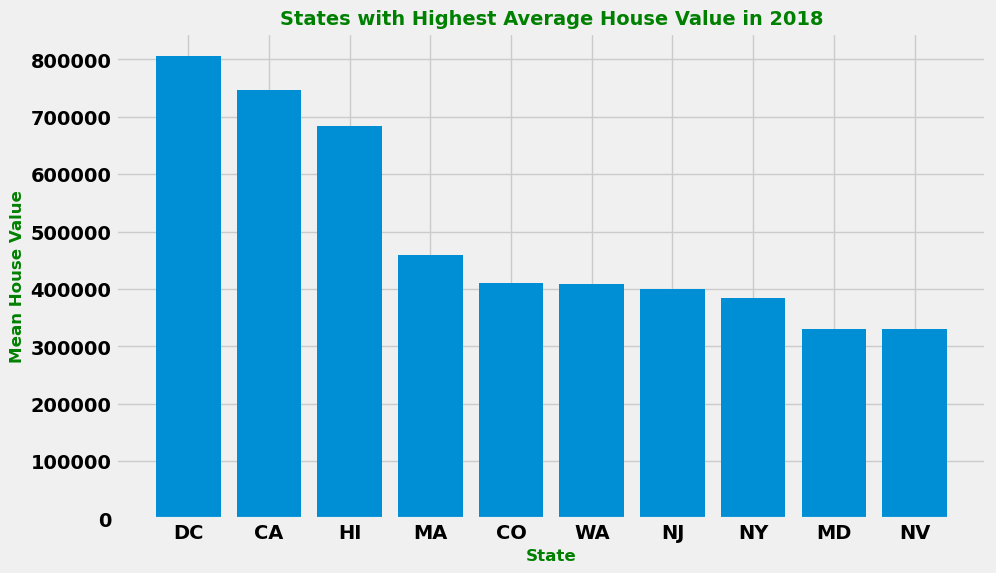

In [32]:
#Top 10 states to inverst in 2018 April.
date_column = pd.Timestamp('2018-04-01 00:00:00')

# Group by 'ZipCode', then aggregate by summing the values for the specific date
top_10 = data.groupby('State')[date_column].mean().nlargest(10)

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(top_10.index, top_10.values)

#setting the labels
ax.set_xlabel('State', fontsize=12, color='green', fontweight='bold', fontname='sans-serif')
ax.set_ylabel('Mean House Value', size = 12, weight = 'bold', color = 'Green', fontname='sans-serif')
ax.set_title('States with Highest Average House Value in 2018', color= 'Green', weight = 'bold', 
                        size= 14, fontname='sans-serif');


- The average price of a house in DC in 2018 was USD800000 and USD350000 in Nevada.

- Looking at these states, you notice they have diversified economies. California, for instance, is home to Silicon Valley, Hollywood, and major agricultural sectors. Massachusetts has a strong educational and healthcare sector. DC is the political center of the country, and Hawaii has a robust tourism industry. 

- All these factors create a competitive market where housing prices are driven to high levels due to the attractiveness of these states for living, working, and investing making them the most expensive house markets in the US.

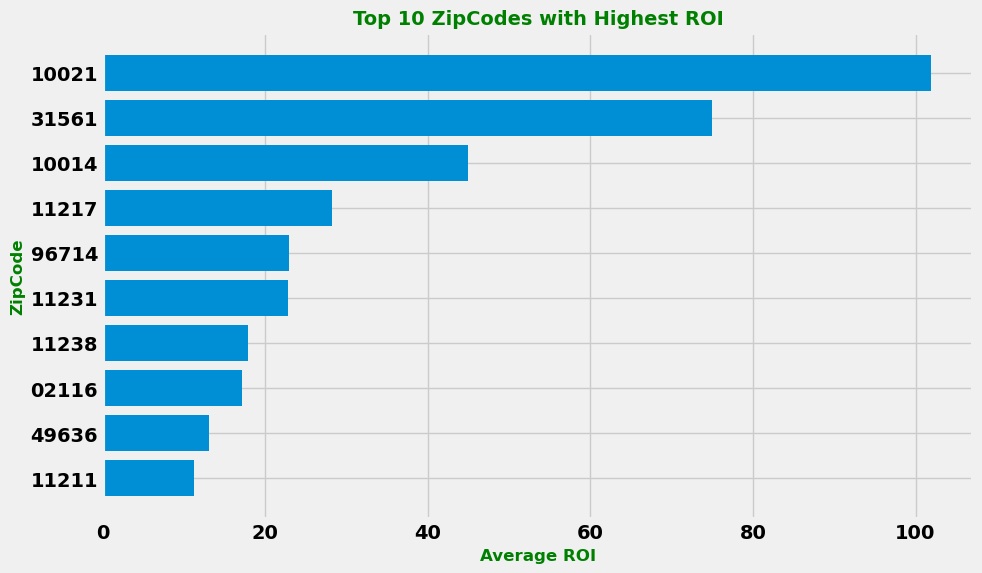

In [33]:
#Top 10 ZipCodes with highest ROI
top10_ROI = data.groupby('ZipCode')['ROI'].mean().nlargest(10)[::-1]

fig, ax = plt.subplots(figsize = (10, 6))

ax.barh(y= top10_ROI.index, width= top10_ROI)


#setting the labels
ax.set_xlabel('Average ROI', fontsize=12, color='green', fontweight='bold', fontname='sans-serif')
ax.set_ylabel('ZipCode', size = 12, weight = 'bold', color = 'Green', fontname='sans-serif')
ax.set_title('Top 10 ZipCodes with Highest ROI', color= 'Green', weight = 'bold', 
                        size= 14, fontname='sans-serif');


**Insights**
- Notably ZipCode 10021 has a significantly higher ROI compared to the other zipcodes. 

    - Looking closely the zipcode is located in the neighborhoods of Manhattan which wealthiest neighborhoods in New York City. 
    - It's known for its luxury real estate, high-end shopping, and proximity to Central Park.
    - High demand and limited supply in this area drive property values up, leading to higher ROI.

- 31561, the second zipcode with significantly higher ROI which is St. Simons Island, Georgia.

    - According to latest statistics, approximately 70% of the households in this neighborhood are Husband Wife Family Households with 94% of the families having atlearst 2 children per family. 
    - From this it's evident the zipcode is particularly attractive to retirees making the real estate market driven by demand for second homes and retirement properties.

    - Also the island's scenic beauty and amenities make it a desirable place to live, contributing to higher property values and ROI.
- 10014  is located in New York - West Village.
    - The trendy Neighborhood of the zipcode brings high demand due to its historic charm and proximity to entertainment.
    - It's close to downtown Manhattan, attracting professionals and investors.
-  From 11217 there is no significant difference in the ROI. 
    - the zipcodes are mostly residential properties
    - The high ROI maybe attributed to the gentrification and development over the past few decades, making it a highly desirable location.

In [34]:
#more EDA

*Reshape from Wide to Long Format*


In [35]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['ZipCode', 'City', 'State',
                                   'Metro', 'CountyName', 'ROI'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'])
    melted = melted.dropna(subset=['value'])
    return  melted.groupby('time').aggregate({'value':'mean'})

In [36]:
#copying the data
df = data.copy()

In [37]:
#reshaping the new df to long format

df = melt_data(data)

In [38]:
#Renaming the value to mean
df.rename(columns= {'value': 'Mean_Value'}, inplace= True)

In [39]:
df.tail(12)

,Mean_Value
time,
2017-05-01,270226.84
2017-06-01,271824.72
2017-07-01,273335.39
2017-08-01,274865.77
2017-09-01,276464.62
2017-10-01,278033.19
2017-11-01,279520.86
2017-12-01,281095.32
2018-01-01,282657.06


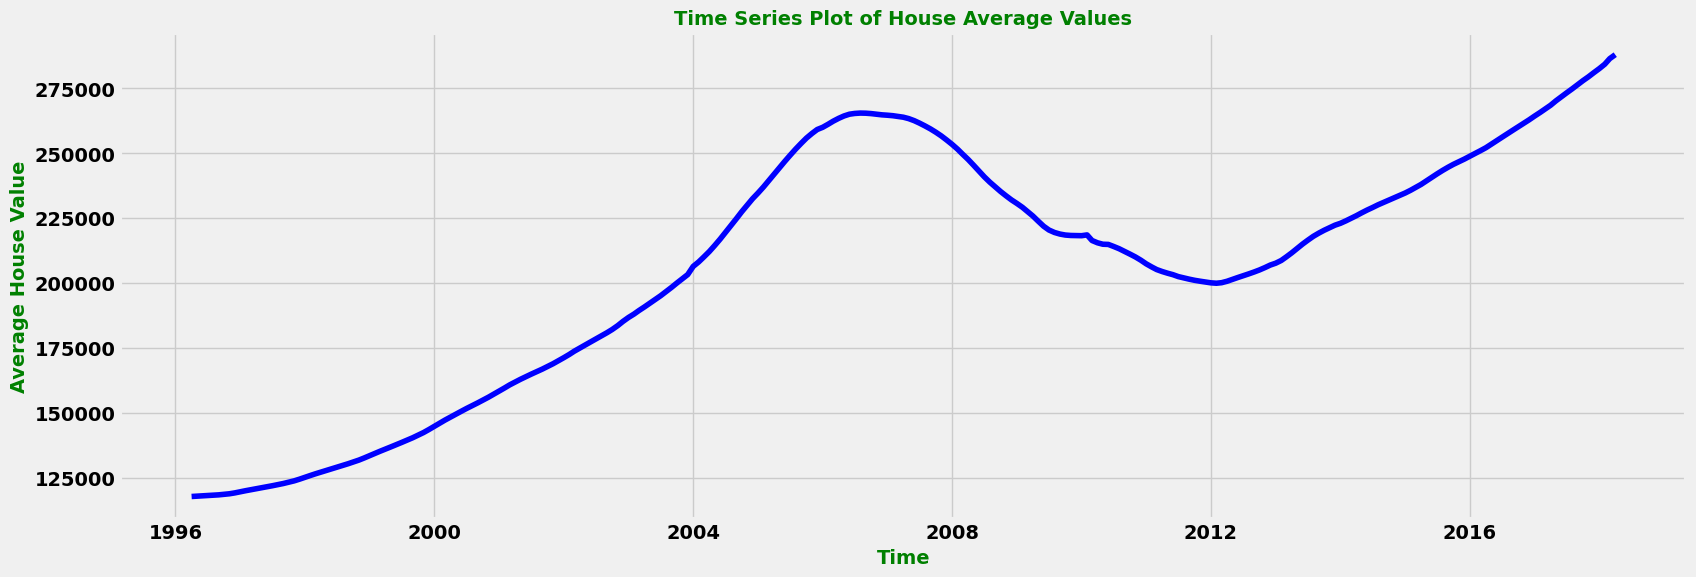

In [40]:
#ploting the trend in the value of the houses
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df, color = 'b')
plt.xlabel('Time', color= 'Green', weight = 'bold', size= 14, fontname='sans-serif')
plt.ylabel('Average House Value', color= 'Green', weight = 'bold', size= 14, fontname='sans-serif')

plt.title('Time Series Plot of House Average Values', color= 'Green', 
                            weight = 'bold', size= 14, fontname='sans-serif');


- The trend appears cyclical with an overall upward trajectory over time.
- The average value of houses increased significantly from 1996 to 2018.
- The pattern shows periods of growth, followed by dips or plateaus, then resuming upward. This cyclical nature reflects economic and market cycles.
- The plot peaks around 2007-2008 due to several factors:
  - Early 2000s: The Federal Reserve kept interest rates low, making borrowing cheaper. This increased mortgage lending and housing demand, driving up house values.
  - 2007-2008: Interest rates reset higher, leading to many homeowners, especially with subprime mortgages, defaulting on loans. Increased defaults led to foreclosures, flooding the market with homes and causing prices to plummet.
- Post-2008 decline explained by the Great Recession:
  - The financial crisis led to widespread unemployment, reduced consumer spending, and a lack of economic confidence, further depressing house prices.
  - Banks tightened lending standards, making it harder for buyers to get mortgages, reducing housing demand.
- Post-2012 rise attributed to economic stabilization:
  - The economy began stabilizing, with improving unemployment rates and consumer confidence.
  - The Federal Reserve kept interest rates low to stimulate the economy, making borrowing more affordable and encouraging home purchases.

**Checking for Stationarity**

In [41]:
# Determine rolling statistics
roll_mean = df.rolling(window=12, center=False).mean()
roll_std = df.rolling(window=12, center=False).std()

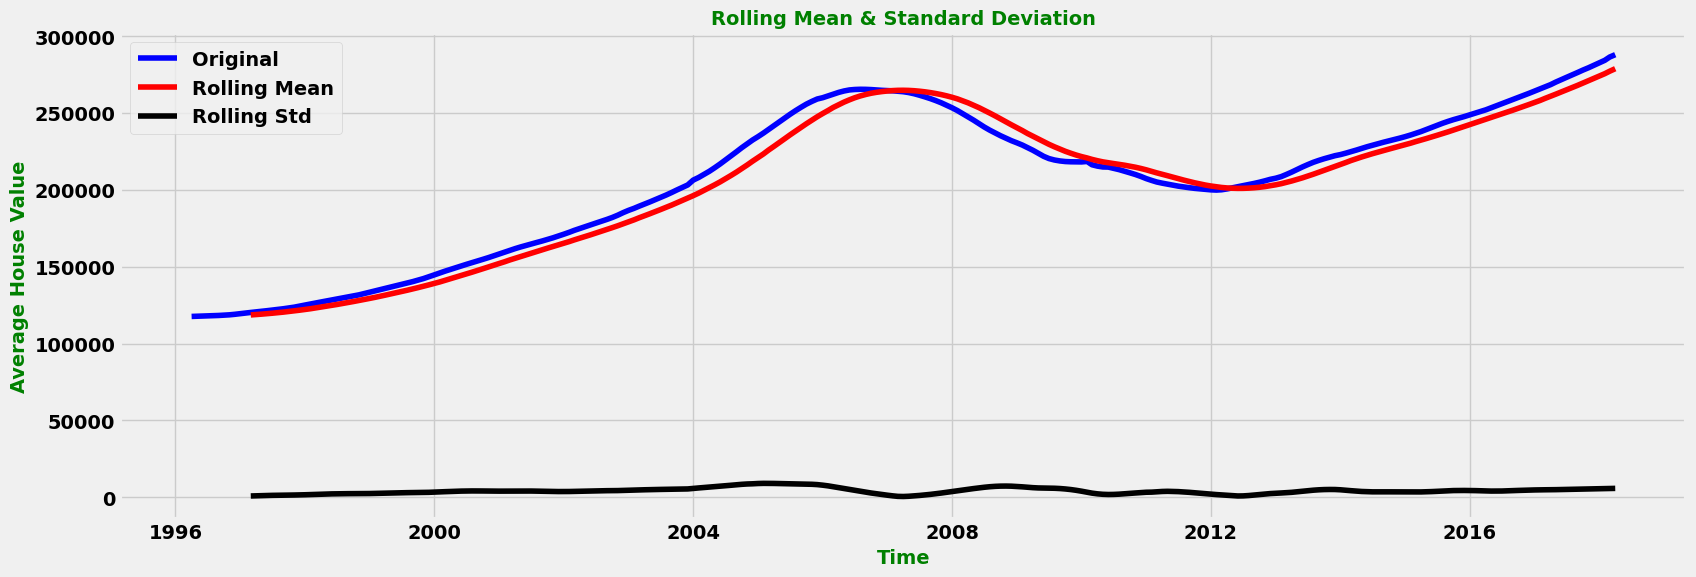

In [42]:
# Plot rolling statistics
fig = plt.figure(figsize=(18,6))
plt.plot(df, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.xlabel('Time', color= 'Green', weight = 'bold', size= 14, fontname='sans-serif')
plt.ylabel('Average House Value', color= 'Green', weight = 'bold', size= 14, fontname='sans-serif')
plt.title('Rolling Mean & Standard Deviation', color= 'Green', weight = 'bold', 
                        size= 14, fontname='sans-serif')
plt.show()

- The rolling mean closely follows the original data, indicating a strong trend component. The rolling standard deviation remains relatively stable over time, suggesting that the variability of the series does not change significantly, although the trend does.

In [43]:
# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(df['Mean_Value'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                 -1.91
p-value                         0.33
#Lags Used                      2.00
Number of Observations Used   262.00
Critical Value (1%)            -3.46
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


- The results of the Dickey-Fuller Test indicate that the test statistic is -1.89, with a p-value of 0.34. 

- Since the test statistic is less negative than the critical values at the 1%, 5%, and 10% significance levels (-3.46, -2.87, and -2.57, respectively), and the p-value is higher than the typical thresholds for significance (0.01, 0.05, 0.10), we fail to reject the null hypothesis of the test. 

- Therefore there is insufficient evidence to conclude that the time series is stationary,  meaning the serries likely contains a unit root and therfore exhibits non-stationarity.

## ARIMA Modelling

*Removing Trend*

**Option #1**

In [44]:
#Defining function to check for stationarity
def check_stationarity(series):
    #extract pvalue from adfauler test

    p_value = adfuller(series)[1]

    print(f"p-value:{p_value}")

    if p_value <= 0.05:
        print("""Strong evidence against the null hypothesis, 
              reject the null hypothesis. Series has no unit root and is stationary""")
    else:
        print("""Weak evidence against null hypothesis,
               time series has a unit root, indicating it is non-stationary """)


In [45]:
# 1-lag difference

df_diff_1 = df.diff(periods= 1).dropna()

In [46]:
#check for stationarity at lag 1

check_stationarity(df_diff_1)

p-value:0.10150863646096386
Weak evidence against null hypothesis,
               time series has a unit root, indicating it is non-stationary 


The serries still exibits non-stationarity at lag 1. However you notice the p-value has significantly dropped.

We proceed to 12 month lag difference.

In [47]:
df_diff_12 = df.diff(periods= 12).dropna()

In [48]:
#check for stationarity
check_stationarity(df_diff_12)

p-value:0.3276232966396624
Weak evidence against null hypothesis,
               time series has a unit root, indicating it is non-stationary 


Well, that is even worse than the p-value at 1 month lag difference. 

Considering the housing market, the market has multi-year cycles influenced by broader economic factors, such as interest rate changes, economic cycles, and policy changes. as we noticed in during the EDA. Therefore 12 month lag difference may still capture these trends, leading to higher p-values.


We proceed to try 24 months lag difference

In [49]:
#conducting 12 month lag difference
df_diff_24 = df.diff(periods= 24).dropna()


#checking for stationarity

check_stationarity(df_diff_24)

p-value:0.0258893978119642
Strong evidence against the null hypothesis, 
              reject the null hypothesis. Series has no unit root and is stationary


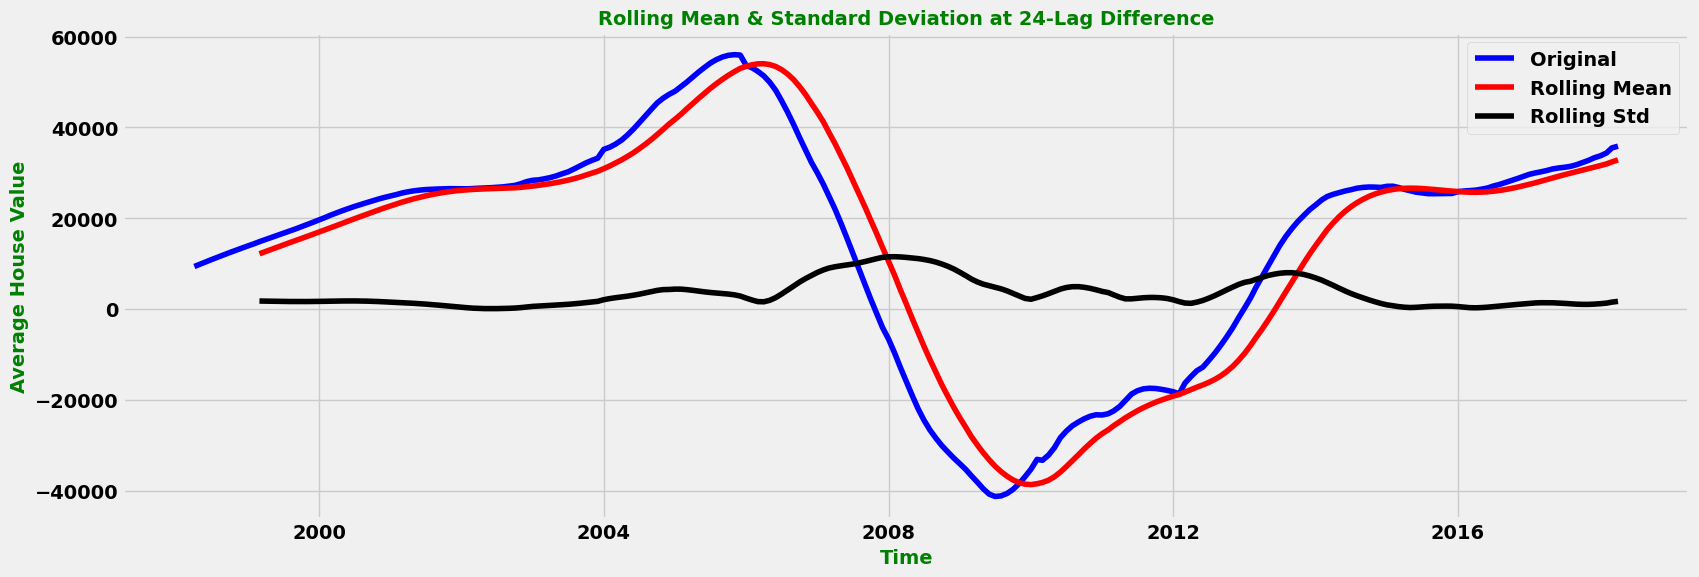

In [50]:
#viewing the visual feel of the series after 24-lag difference

# Determining  rolling statistics
roll_mean = df_diff_24.rolling(window=12, center=False).mean()
roll_std = df_diff_24.rolling(window=12, center=False).std()

# Plot rolling statistics
fig = plt.figure(figsize=(18,6))
plt.plot(df_diff_24, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.xlabel('Time', color= 'Green', weight = 'bold', size= 14, fontname='sans-serif')
plt.ylabel('Average House Value', color= 'Green', weight = 'bold', size= 14, fontname='sans-serif')
plt.title('Rolling Mean & Standard Deviation at 24-Lag Difference', color= 'Green', weight = 'bold', 
                        size= 14, fontname='sans-serif')
plt.show()


Yay!! 
- The rolling mean (red line) remains relatively flat, especially in the latter part of the time series, indicating that the series is now more stationary. 

- The rolling standard deviation (black line) remains fairly stable after the initial large fluctuations. This suggests that the variability in the data is consistent over time, another indicator of stationarity.

- The peaks in the rolling standard deviation around the 2008 financial crisis and the post-2012 recovery period reflect periods of higher volatility in house prices.

- The results from the plot is confirmed by the Adfauler test result therefore the 24-month lag difference finally captures and adjusts for these complexities, leading to stationarity in the housing value series.

**Autocorrelation**

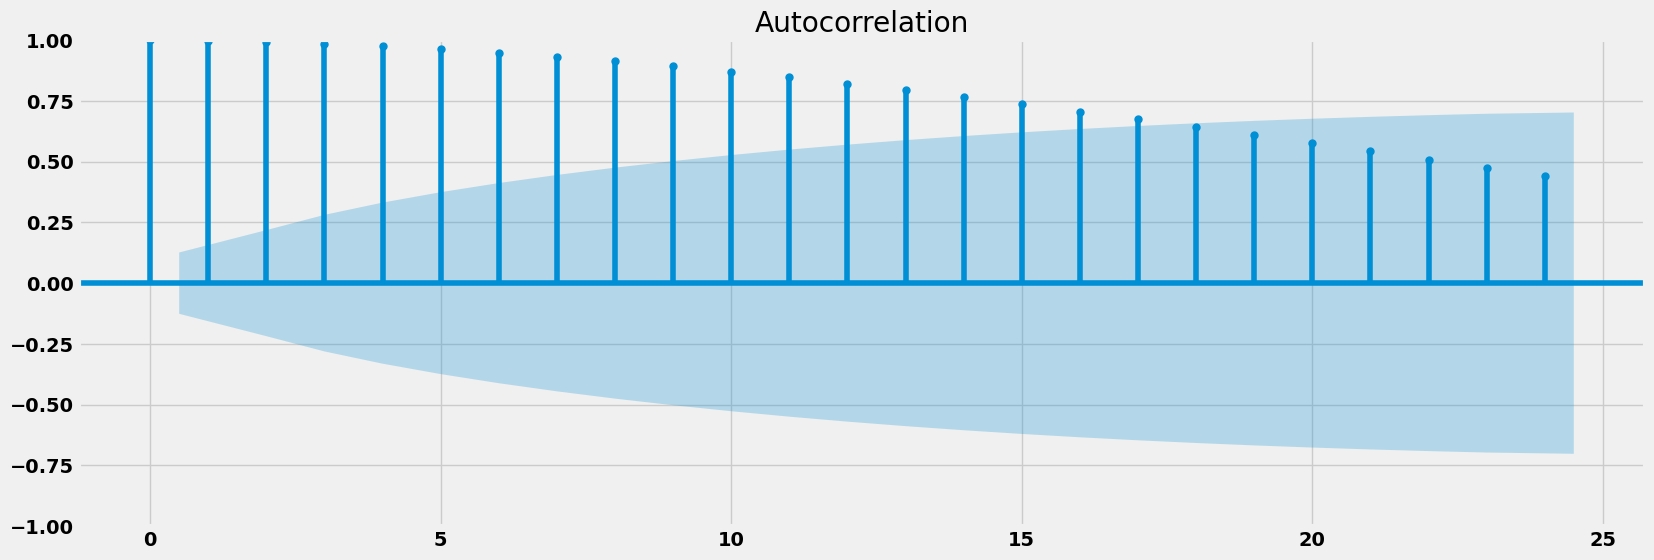

In [51]:
# plotting autocorrelation Function
fig, ax = plt.subplots(figsize = (18, 6))
acf = plot_acf(df_diff_24, ax= ax)

*insights*

- The ACF shows high values at initial lags, indicating strong correlation with past values.
- The autocorrelation gradually decreases as the number of lags increases.
- The slow decline in the ACF suggest that the series has a long memory or persistence, which is typical in housing market where prices are influenced by long-term trends and cycles.



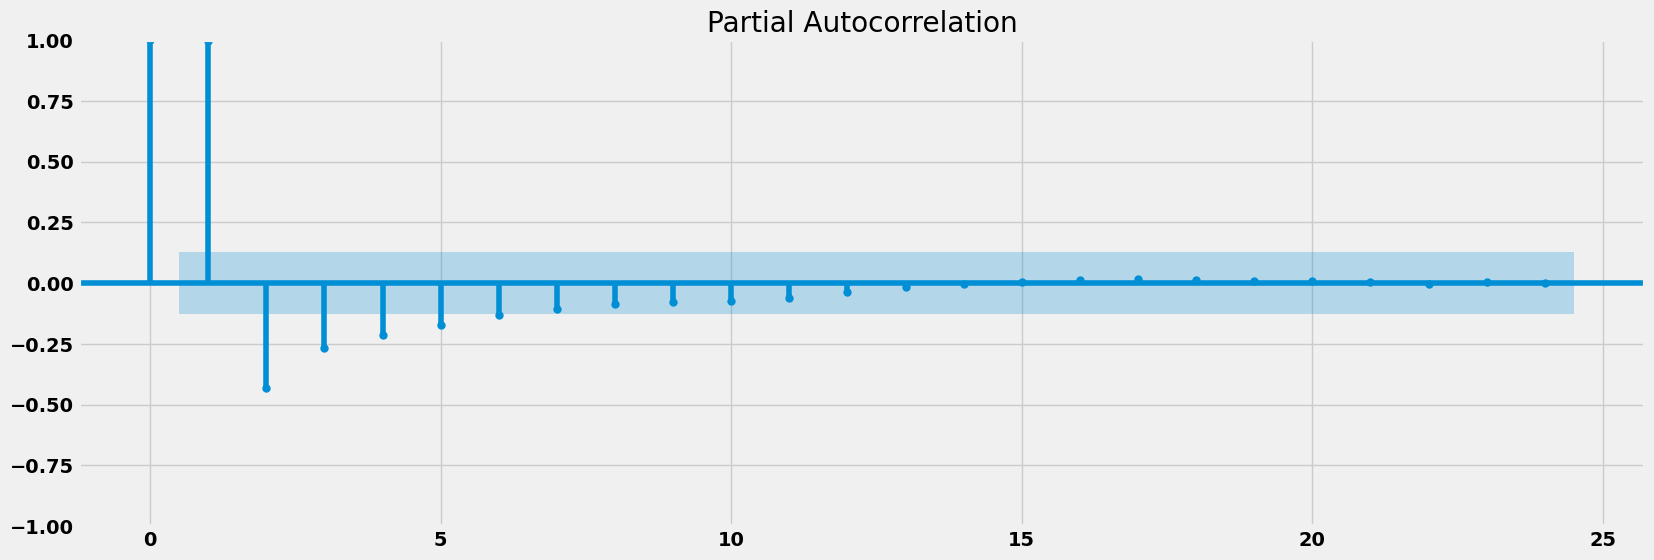

In [52]:
#ploting PACF
fig, ax = plt.subplots(figsize = (18, 6))
acf = plot_pacf(df_diff_24, ax= ax)

*Insights*

- The PACF shows significant spikes at the first few lags.
- After the first few significant lags, the partial autocorrelation quickly drops to near zero. This suggests that the immediate past values (such as the first lag) are the most important, and beyond that, the influence is minimal.

-  The ACF and PACF plots together indicate that the differenced series has strong short-term autocorrelation with diminishing influence over time. 

**Modeling**

In [77]:
#setting parameters
params = {'p': [1, 2, 3, 4, 5],
          'q': [1, 3, 5, 10, 15, 16, 17]}

#pairring the parameter to find the combination with the best performance
for p in params['p']:
    for q in params['q']:
        order = (p, 2, q)

        print(order)

(1, 2, 1)
(1, 2, 3)
(1, 2, 5)
(1, 2, 10)
(1, 2, 15)
(1, 2, 16)
(1, 2, 17)
(2, 2, 1)
(2, 2, 3)
(2, 2, 5)
(2, 2, 10)
(2, 2, 15)
(2, 2, 16)
(2, 2, 17)
(3, 2, 1)
(3, 2, 3)
(3, 2, 5)
(3, 2, 10)
(3, 2, 15)
(3, 2, 16)
(3, 2, 17)
(4, 2, 1)
(4, 2, 3)
(4, 2, 5)
(4, 2, 10)
(4, 2, 15)
(4, 2, 16)
(4, 2, 17)
(5, 2, 1)
(5, 2, 3)
(5, 2, 5)
(5, 2, 10)
(5, 2, 15)
(5, 2, 16)
(5, 2, 17)


In [54]:
#separating the test set and training set
cutoff = int(len(df) * 0.85)

y_train = df.iloc[: cutoff]

y_test = df.iloc[cutoff:]

In [58]:
# result = sm.tsa.seasonal_decompose(df['Mean_Value'], model='additive', period= 24)

# df['Seasonal_Adjusted'] = result.resid

# # Plotting the seasonal-adjusted time series
# plt.figure(figsize=(15, 8))
# plt.plot(df['Seasonal_Adjusted'], label='Seasonally Adjusted Data', color='blue')
# plt.title('Seasonally Adjusted Time Series', fontsize=16)
# plt.xlabel('Time', fontsize=12)
# plt.ylabel('Values', fontsize=12)
# plt.legend()
# plt.grid(True)
# plt.show()


In [78]:
# Create dictionary to store MAEs
mae_grid = {}

# Outer loop: Iterate through possible values for `p`
for p in params['p']:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    
    # Inner loop: Iterate through possible values for `q`
    for q in params['q']:
        # Combination of hyperparameters for model
        order = (p, 2, q)

        # Note start time
        start_time = time.time()

        # Train model
        model = ARIMA(y_train, order = order).fit()

        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")

        # Generate in-sample (training) predictions
        y_pred = model.predict()

        # Calculate training MAE
        mae = mean_absolute_error(y_train, y_pred)
        
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (1, 2, 1) in 0.25 seconds.
Trained ARIMA (1, 2, 3) in 0.31 seconds.
Trained ARIMA (1, 2, 5) in 0.37 seconds.
Trained ARIMA (1, 2, 10) in 1.71 seconds.
Trained ARIMA (1, 2, 15) in 2.67 seconds.
Trained ARIMA (1, 2, 16) in 4.58 seconds.
Trained ARIMA (1, 2, 17) in 4.88 seconds.
Trained ARIMA (2, 2, 1) in 0.2 seconds.
Trained ARIMA (2, 2, 3) in 0.27 seconds.
Trained ARIMA (2, 2, 5) in 0.23 seconds.
Trained ARIMA (2, 2, 10) in 1.18 seconds.
Trained ARIMA (2, 2, 15) in 3.72 seconds.
Trained ARIMA (2, 2, 16) in 4.85 seconds.
Trained ARIMA (2, 2, 17) in 3.82 seconds.
Trained ARIMA (3, 2, 1) in 0.31 seconds.
Trained ARIMA (3, 2, 3) in 0.91 seconds.
Trained ARIMA (3, 2, 5) in 0.57 seconds.
Trained ARIMA (3, 2, 10) in 1.78 seconds.
Trained ARIMA (3, 2, 15) in 3.44 seconds.
Trained ARIMA (3, 2, 16) in 4.1 seconds.
Trained ARIMA (3, 2, 17) in 4.18 seconds.
Trained ARIMA (4, 2, 1) in 0.13 seconds.
Trained ARIMA (4, 2, 3) in 0.9 seconds.
Trained ARIMA (4, 2, 5) in 1.56 seconds.
Trained

In [81]:
mae_df = pd.DataFrame(mae_grid, index= params['q'])
mae_df.round(4)

,1,2,3,4,5
1,930.45,930.58,930.99,931.10,931.09
3,931.22,931.16,933.20,932.88,930.62
5,931.14,931.29,930.90,930.56,932.09
10,930.85,931.58,931.35,931.35,931.36
15,930.10,930.11,929.84,930.74,931.02
16,930.12,930.11,930.10,932.74,930.24
17,930.26,930.32,933.54,930.84,933.62


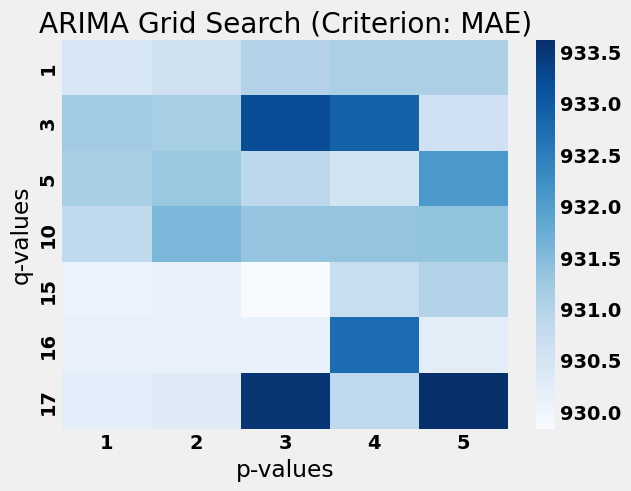

In [82]:
sns.heatmap(mae_df, cmap= 'Blues')
plt.xlabel('p-values')
plt.ylabel('q-values')
plt.title('ARIMA Grid Search (Criterion: MAE)');

In [83]:
#picking the best model

model_best = ARIMA(y_train, order=(3, 2, 15)).fit()

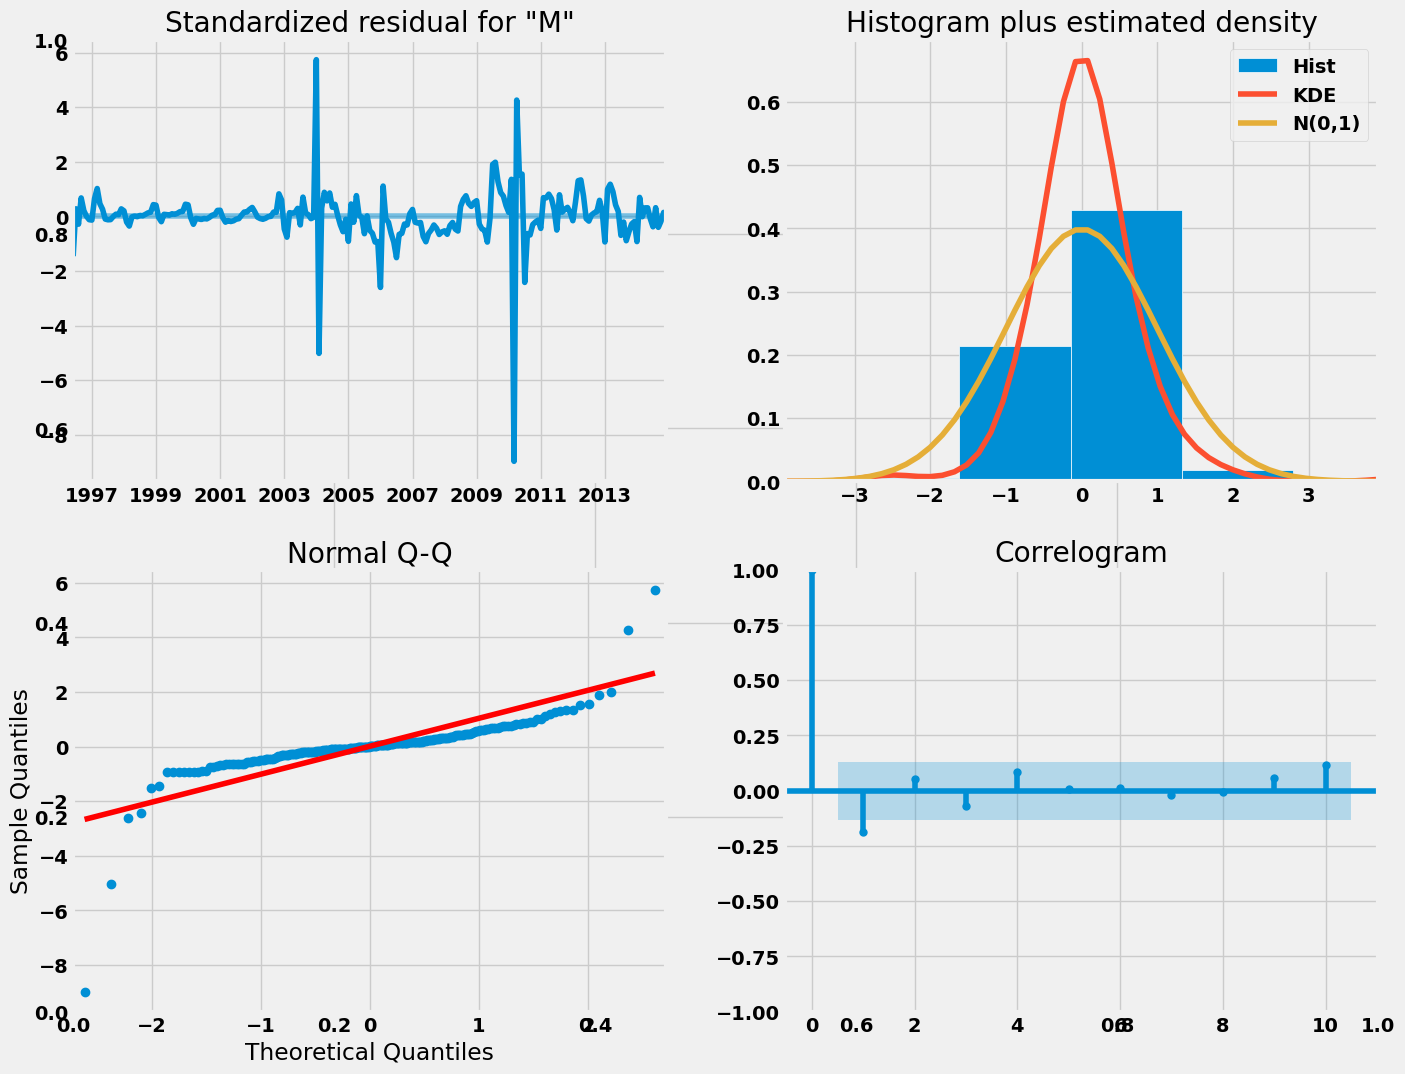

In [85]:
fig, ax = plt.subplots(figsize=(15, 12))

model_best.plot_diagnostics(fig= fig);

**Evaluation**

We shall perform a walk forward validation of the model performance on the test set.

In [91]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history, order= (3, 2, 15)).fit()
    next_pred = model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    history = pd.concat([history, y_test[next_pred.index]])

KeyError: "None of [DatetimeIndex(['2015-01-01'], dtype='datetime64[ns]', freq='MS')] are in the [columns]"

In [ ]:
#printing out the best
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))